In [1]:
import os
import re
import h5py
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle as pkl

import nltk
from nltk.corpus import stopwords
languages = ['english', 'german', 'french', 'finnish', 'swedish', 'norwegian', 'danish', 'russian']
stop_words = set()
for language in languages:
    stop_words.update(set(stopwords.words(language)))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

from mlxtend.classifier import StackingClassifier
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler, SMOTE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

import lightgbm as lgb

Using TensorFlow backend.


# Data

The data is formatted as an array comprised of one independent variable (lyrics) and five dependent variable labels (genres), for each row (song). Since each song can belong to any ore none of the genres, the task of tagging song lyrics with the appropriate genre labels is a multi-label classification problem.

In [2]:
df = pd.read_hdf('combined-data/lyrics-genres.h5', key='df', mode='r')
X = df.pop('lyrics').values
y = df.values
genres = df.columns

# Multi-label classification tools

**Binary relevance** is the simplest method of classifying multiple labels at once; it trains an independant classifier for each label, breaking the multi-label problem down into many binary classification problems ([Zhang, M., Li, Y., Liu, X., et al, 2018](http://palm.seu.edu.cn/zhangml/files/FCS'17.pdf)). In this context a binary classifier would be trained on each genre, and a song's genre tags predicted by concatenating the predictions of all genre classifiers. The advantage of this method is that the number of classifiers needed is equal to the number of labels, so the computational cost scales linearly with how many labels we want to predict. However, by assuming that the labels are independent, this method fails to capture correlations between labels. For example, the "heavy" and "power" genre labels are more likely to appear together, so an song's likelihood of being tagged as power metal should be higher if it is also tagged as heavy metal as opposed to, say, black metal. Another issue is that each binary classifier will face a class imbalance problem due to the sparsity of genre tags.

In the **classifier chain** method, a classifier is trained on one label and its output is fed as an additional feature to the next label, and so on until all labels have been exhausted ([Read, J., Pfahringer, B., Holmes., G, Frank, E. 2011](https://www.cs.waikato.ac.nz/~eibe/pubs/chains.pdf)). This again requires only as many classifiers as there are labels, but unlike binary relevance it does learn correlations between labels. However, the correlations it is capable of learning can vary with different chain orders.

Unlike the above two methods, which transform the multi-label problem into multiple independant binary classification problems, the **label powerset** method transforms it into a single multi-class problem by treating every combination of labels as its own class. For example, from the genres in the metal lyrics dataset, "black" + "death", "black" + "power", "black" + "death" + "power" would each yield a new class. This tackles the issue of correlated labels head-on by treating correlations as classes on their own, but comes at the cost of having smaller class sizes to train on and consequently an even bigger class imbalance problem. This issue inspired the **RAndom k-labELsets (RAKEL)** method, which uses an ensemble of classifiers, each trained on a random subset of labels ([Rokach, L., Schclar, A., Itach, E. 2013](https://arxiv.org/ftp/arxiv/papers/1307/1307.1769.pdf)).

In [11]:
class BinaryRelevance:
    def __init__(self, classifier, labels):
        self.classifier = classifier
        self.labels = labels
        self.classifiers_ = {}

    def fit(self, X, y):
        for i in range(y.shape[1]):
            print('training binary classifier for label: {}'.format(i))
            clf = deepcopy(self.classifier)
            clf.fit(X, y[:, i])
            self.classifiers[i] = clf

    def predict(self, X):
        y = np.zeros((X.shape[0], len(self.classifiers_)))
        for i, clf in self.classifiers_.items():
            y[:, i] = clf.predict(X)
        return y

    def cross_validate(self, X, y, n_splits=5, verbose=False):
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
        y_prob, y_valid = np.zeros(y.shape), np.zeros(y.shape)
        for i, label in enumerate(self.labels):
            if verbose:
                print("Training on label '{}'".format(label))
            scores = np.zeros((n_splits, 4))
            confusion_matrices = np.zeros((n_splits, 2, 2))
            for j, (train_idx, valid_idx) in enumerate(kfold.split(X, y[:, i])):
                if verbose:
                    print("Fold {}/{}".format(j + 1, n_splits))
                X_fold_train, y_fold_train = X[train_idx], y[train_idx, i]
                X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx, i]
                clf = deepcopy(self.classifier)
                clf.fit(X_fold_train, y_fold_train)
                try:
                    y_fold_prob = clf.predict_proba(X_fold_valid)[:, 1]
                except AttributeError:
                    y_fold_prob = clf.predict(X_fold_valid).reshape(-1)
                y_prob[valid_idx, i] = y_fold_prob
                y_valid[valid_idx, i] = y_fold_valid
                y_fold_pred = y_fold_prob.round()
                scores[j, 0] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
                scores[j, 1] = precision_score(y_fold_valid, y_fold_pred)
                scores[j, 2] = recall_score(y_fold_valid, y_fold_pred)
                scores[j, 3] = f1_score(y_fold_valid, y_fold_pred)
                confusion_matrices[j] = confusion_matrix(y_fold_valid, y_fold_pred)
            if verbose:
                avg_accuracy, avg_precision, avg_recall, avg_f1 = scores.mean(axis=0)
                std_accuracy, std_precision, std_recall, std_f1 = scores.std(axis=0)
                print("CV scores:")
                print("Accuracy:    {:.2f} +/- {:.2f}".format(avg_accuracy, std_accuracy))
                print("Precision:   {:.2f} +/- {:.2f}".format(avg_precision, std_precision))
                print("Recall:      {:.2f} +/- {:.2f}".format(avg_recall, std_recall))
                print("F1-score:    {:.2f} +/- {:.2f}".format(avg_f1, std_f1))
                print("Average confusion matrix:")
                print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)
        return MultiLabelClassification(y_valid, y_prob, labels=self.labels)

# Evaluation metrics

Since binary relevance involves training independant binary classifiers, each classifier can be evaluated during training and cross-validation using the familiar binary classication metrics.

However, evaluating the overall results requires metrics designed for the multi-label output, which are more complicated than the usual evaluation metrics ([Zhang, M., Zhou, Z. 2014](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkde13rev.pdf)). If $h(\mathbf{x}_i)$ is the model which predicts the labels $Y_i$ based on the independent variables $\mathbf{x}_i$, then over $p$ observations the accuracy, precision, recall, and F scores are defined as

\begin{align}
\mathrm{accuracy}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ labels\ in\ common}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|Y_i \cup h(\mathbf{x}_i)|}\\
\mathrm{precision}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ predicted\ labels\ that\ are\ correct}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|h(\mathbf{x}_i)|}\\
\mathrm{recall}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ true\ labels\ that\ were\ predicted\ correctly}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|Y_i|}\\
\mathrm{F_1\ score}(h) &= \mathrm{harmonic\ mean\ of\ precision\ and\ recall} &= 2 \left[ \frac{\mathrm{precision}(h) \cdot \mathrm{recall}(h)}{\mathrm{precision}(h) + \mathrm{recall}(h)} \right]
\end{align}

Another useful metric is the Hamming loss, which is the mean symmetric difference (non-matching genre tags) between the two sets:

$$\mathrm{Hamming}(h) = \frac{1}{p} \sum_{i=1}^{p} |h(\mathbf{x}_i\Delta Y_i|$$

In [12]:
class MultiLabelClassification:

    def __init__(self, y_true, y_pred=None, y_pred_classes=None, labels=None, class_thresh=0.5):
        self.true = y_true.astype(int)
        if y_pred_classes is None and y_pred is not None:
            self.pred = y_pred
            y_pred_classes = np.zeros_like(self.pred, dtype=int)
            y_pred_classes[self.pred > class_thresh] = 1
        else:
            self.pred = None
        self.pred_classes = y_pred_classes
        self.n_samples, self.n_labels = y_true.shape
        if labels is not None:
            if len(labels) == self.n_labels:
                self.labels = np.array(labels)
            else:
                raise ValueError("length of labels and shape of y_true do not match")
        else:
            self.labels = np.arange(self.true.shape[1])

    @property
    def __intersection(self):
        return self.true * self.pred_classes

    @property
    def __union(self):
        return np.minimum(1, self.true + self.pred_classes)

    @property
    def accuracy_score(self):
        # Number of labels in common / overall labels (true and predicted)
        return np.nanmean(self.__intersection.sum(1) / self.__union.sum(1))

    @property
    def precision_score(self):
        # Proportion of predicted labels that are correct
        return np.nanmean(self.__intersection.sum(1) / self.pred_classes.sum(1))

    @property
    def recall_score(self):
        # Proportion of true labels that were predicted
        return np.nanmean(self.__intersection.sum(1) / self.true.sum(1))

    @property
    def f1_score(self):
        # Harmonic mean of precision_score and recall_score
        p = self.precision_score
        r = self.recall_score
        return 2 * (p * r) / (p + r)

    @property
    def hamming_loss(self):
        # Symmetric difference b/w pred and true labels (true XOR pred)
        delta = np.zeros(self.true.shape[0])
        for i in range(delta.shape[0]):
            delta[i] = np.sum(self.true[i] ^ self.pred_classes[i])
        return delta.mean()

    def confusion_matrix(self, label=None, label_idx=None):
        confusion_matrices = multilabel_confusion_matrix(self.true, self.pred_classes)
        if label is not None:
            return confusion_matrices[np.where(self.labels == label)[0][0]]
        elif label_idx is not None:
            return confusion_matrices[label_idx]
        else:
            return confusion_matrices

    def print_report(self, verbose=0):
        print("Multi-label classification report:")
        print("Accuracy:      {:.2f}".format(self.accuracy_score))
        print("Precision:     {:.2f}".format(self.precision_score))
        print("Recall:        {:.2f}".format(self.recall_score))
        print("F1-score:      {:.2f}".format(self.f1_score))
        print("Hamming loss:  {:.2f}".format(self.hamming_loss))
        if verbose == 1:
            for label, matrix in zip(self.labels, self.confusion_matrix()):
                print("===\nLabel: {}".format(label))
                print(matrix)

    def plot_roc_curve(self):
        fig = plt.figure(figsize=(8, 6))
        auc = np.zeros(len(self.labels))
        for i, label in enumerate(self.labels):
            true = self.true[:, i]
            pred = self.pred[:, i]
            fpr, tpr, thresholds = roc_curve(true, pred)
            auc[i] = roc_auc_score(true, pred)
            plt.step(fpr, tpr, label=label)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.gca().set_aspect('equal')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.title("ROC curve", size=20)
        plt.xlabel("False positive rate", size=16)
        plt.ylabel("True positive rate", size=16)
        plt.legend(fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(alpha=0.5)
        return fig, auc

# Pipeline

To big steps must be performed before a model can be trained on this dataset:

1. **Vectorization**: To transform the data from raw song lyrics to an array of values ready for training, the lyrics must be vectorized with a bag-of-words method. The `CountVectorizer` turns song's lyrics into a list of word counts. The dataset is thus converted into a matrix representing the term frequency of each word (column) in each song (row). The `TfidfVectorizer` takes this an extra step by computing the term-frequency inverse-document-frequency (TF-IDF) value for each term in a document (song). This quantity measures the frequency of a term in a document relative to its frequency in all documents, thus being a better measure of how unique the term is to that document. These bag-of-words methods fail to capture any syntactical structure in the lyrics, which may be important for genre labeling. A word embedding approach provides a more context-rich representation of the lyrics, and opens up the possibility of training convolutional neural networks over the full documents. This is explored in the next chapter.

2. **Oversampling**: To remedy the class imbalance in each single-genre binary classification, the data can be either oversampled or undersampled to have an equal number of positive and negative class occurences. Undersampling requires no manipulation of the data; the classifier is simply trained with a subset of the majority class equal in number to the minority class. This comes at the cost of reducing the amount of data to train from. Oversampling is often preferred over undersampling. The simplest method of oversampling is random oversampling, in which randomly selected rows from the minority class are duplicated during training. Synthetic Minority Oversampling Technique (SMOTE) is a more complex method that generates new data based on the distribution of values in the minority class [Chawla, N., Bowyer, K., Hall, L., Kegelmeyer, W. 2011](https://arxiv.org/abs/1106.1813). It does so by randomly selecting two observations at a time in the minority class and sampling a new observation from the line between those two in the feature space. This is somewhat like producing from randomly selected parent observations a child whose traits are somewhere between those of its parents. In the context of song lyrics SMOTE would generate new songs with word frequencies (or TF-IDF values) similar to the genre being classified by the binary classifier.

# Logistic regression

One very simple model for a binary classification task is the [logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) classifier, which assumes a linear relationship between the feature variables (word counts) and the log-odds of the target variables (genre).

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.74 +/- 0.00
Precision:   0.56 +/- 0.00
Recall:      0.63 +/- 0.01
F1-score:    0.59 +/- 0.00
Average confusion matrix:
[[0.66009833 0.11362963]
 [0.08359824 0.1426738 ]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.70 +/- 0.00
Precision:   0.57 +/- 0.01
Recall:      0.61 +/- 0.00
F1-score:    0.59 +/- 0.00
Average confusion matrix:
[[0.53669516 0.14472723]
 [0.12444962 0.19412798]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.70 +/- 0.00
Precision:   0.45 +/- 0.00
Recall:      0.53 +/- 0.01
F1-score:    0.48 +/- 0.01
Average confusion matrix:
[[0.7319091  0.10565285]
 [0.07706281 0.08537524]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.48 +/- 0.01
Recall:      0.57 +/- 0.01
F1-score:    0.52 +/- 0.01
Average confusion matrix:
[[0.72258969 0.10642289]
 [0.07271902 0.09826841]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.06


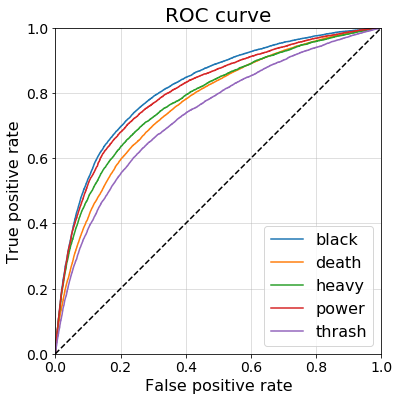

[0.81953027 0.76575025 0.78223942 0.80688227 0.73462532]
AUC ROC score = 0.78 +/- 0.03


In [13]:
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('logreg', LogisticRegression(**lr_params))
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# SGD Classifier

The scikit-learn [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) is a generalized classifier that trains via stochastic gradient descent (SGD). It can assume the form of a logistic regression if using 'log' loss, but by default it uses the 'hinge' loss in which case the linear model it fits is a linear support vector machine (SVM).

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.54 +/- 0.01
Recall:      0.59 +/- 0.01
F1-score:    0.56 +/- 0.01
Average confusion matrix:
[[0.66073015 0.11299781]
 [0.09345075 0.13282129]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.68 +/- 0.00
Precision:   0.56 +/- 0.00
Recall:      0.58 +/- 0.01
F1-score:    0.57 +/- 0.00
Average confusion matrix:
[[0.53470097 0.14672142]
 [0.1353091  0.18326851]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.68 +/- 0.01
Precision:   0.43 +/- 0.01
Recall:      0.48 +/- 0.01
F1-score:    0.45 +/- 0.01
Average confusion matrix:
[[0.73269888 0.10486307]
 [0.08434853 0.07808952]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.69 +/- 0.01
Precision:   0.44 +/- 0.01
Recall:      0.50 +/- 0.01
F1-score:    0.47 +/- 0.01
Average confusion matrix:
[[0.71947006 0.10954252]
 [0.08496061 0.08602681]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.10


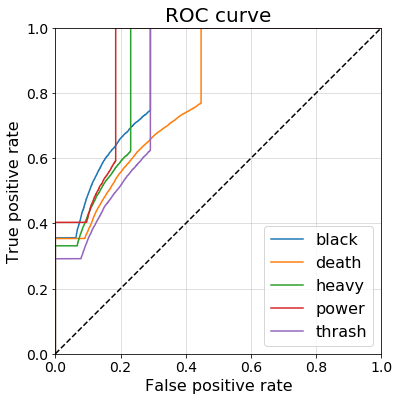

[0.7688474  0.72335291 0.7178901  0.71355291 0.69044885]
AUC ROC score = 0.72 +/- 0.03


In [14]:
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('sgd', SGDClassifier(loss='modified_huber', alpha=0.0001))
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# Naive Bayes

Naive Bayes classifiers have long been popular in text classification.

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.74 +/- 0.00
Precision:   0.60 +/- 0.01
Recall:      0.61 +/- 0.01
F1-score:    0.60 +/- 0.00
Average confusion matrix:
[[0.68219243 0.09153553]
 [0.08873181 0.13754023]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.53 +/- 0.01
Recall:      0.76 +/- 0.00
F1-score:    0.62 +/- 0.00
Average confusion matrix:
[[0.46354177 0.21788062]
 [0.07530555 0.24327206]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.74 +/- 0.01
Precision:   0.36 +/- 0.00
Recall:      0.73 +/- 0.01
F1-score:    0.48 +/- 0.01
Average confusion matrix:
[[0.62566391 0.21189804]
 [0.04326021 0.11917784]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.76 +/- 0.00
Precision:   0.34 +/- 0.00
Recall:      0.85 +/- 0.01
F1-score:    0.49 +/- 0.00
Average confusion matrix:
[[0.54941063 0.27960195]
 [0.0253322  0.14565522]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.39


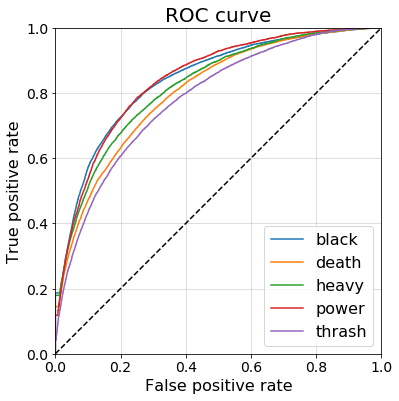

[0.83792592 0.80322112 0.81910882 0.84144829 0.78339261]
AUC ROC score = 0.82 +/- 0.02


In [15]:
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('multinomialnb', MultinomialNB())
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.74 +/- 0.00
Precision:   0.60 +/- 0.01
Recall:      0.61 +/- 0.01
F1-score:    0.60 +/- 0.00
Average confusion matrix:
[[0.68219243 0.09153553]
 [0.08873181 0.13754023]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.53 +/- 0.01
Recall:      0.76 +/- 0.00
F1-score:    0.62 +/- 0.00
Average confusion matrix:
[[0.46354177 0.21788062]
 [0.07530555 0.24327206]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.74 +/- 0.01
Precision:   0.36 +/- 0.00
Recall:      0.73 +/- 0.01
F1-score:    0.48 +/- 0.01
Average confusion matrix:
[[0.62566391 0.21189804]
 [0.04326021 0.11917784]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.76 +/- 0.00
Precision:   0.34 +/- 0.00
Recall:      0.85 +/- 0.01
F1-score:    0.49 +/- 0.00
Average confusion matrix:
[[0.54941063 0.27960195]
 [0.0253322  0.14565522]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.39


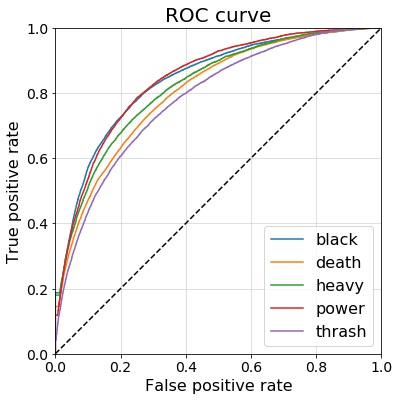

[0.83792566 0.80321494 0.81910219 0.8414475  0.78339295]
AUC ROC score = 0.82 +/- 0.02


In [16]:
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('complementnb', ComplementNB())
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.73 +/- 0.00
Precision:   0.62 +/- 0.01
Recall:      0.56 +/- 0.01
F1-score:    0.59 +/- 0.01
Average confusion matrix:
[[0.69644796 0.07728   ]
 [0.09963078 0.12664126]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.53 +/- 0.00
Recall:      0.74 +/- 0.01
F1-score:    0.62 +/- 0.00
Average confusion matrix:
[[0.47528975 0.20613264]
 [0.08199893 0.23657867]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.73 +/- 0.00
Precision:   0.32 +/- 0.00
Recall:      0.78 +/- 0.01
F1-score:    0.46 +/- 0.00
Average confusion matrix:
[[0.56974747 0.26781448]
 [0.03518471 0.12725334]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.76 +/- 0.00
Precision:   0.34 +/- 0.00
Recall:      0.87 +/- 0.00
F1-score:    0.49 +/- 0.00
Average confusion matrix:
[[0.53418761 0.29482496]
 [0.02158075 0.14940668]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.46


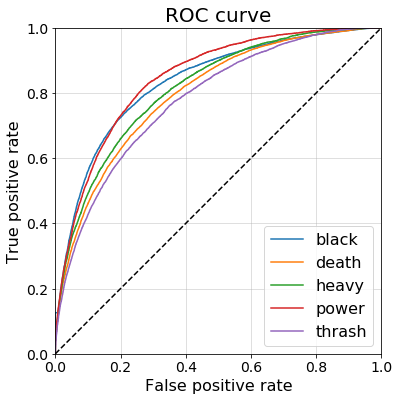

[0.83413697 0.79832941 0.81406839 0.84640479 0.78062993]
AUC ROC score = 0.81 +/- 0.02


In [17]:
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('bernoullinb', BernoulliNB())
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# Random forest classifier

The random forest classifier is a popular choice in classification problems, especially when overfitting is a concern. As an ensemble model, the random forest does a good job of minimizing bias by averaging out the contributions of many hundreds or thousands of predictors.

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.73 +/- 0.00
Precision:   0.47 +/- 0.01
Recall:      0.69 +/- 0.00
F1-score:    0.56 +/- 0.00
Average confusion matrix:
[[0.59622485 0.17750311]
 [0.06975734 0.1565147 ]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.70 +/- 0.00
Precision:   0.58 +/- 0.00
Recall:      0.61 +/- 0.01
F1-score:    0.60 +/- 0.01
Average confusion matrix:
[[0.54368472 0.13773767]
 [0.12525915 0.19331846]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.71 +/- 0.00
Precision:   0.41 +/- 0.00
Recall:      0.59 +/- 0.00
F1-score:    0.48 +/- 0.00
Average confusion matrix:
[[0.69950836 0.13805359]
 [0.0670326  0.09540545]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.74 +/- 0.00
Precision:   0.46 +/- 0.00
Recall:      0.63 +/- 0.00
F1-score:    0.53 +/- 0.00
Average confusion matrix:
[[0.70197643 0.12703615]
 [0.06268881 0.10829862]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.12


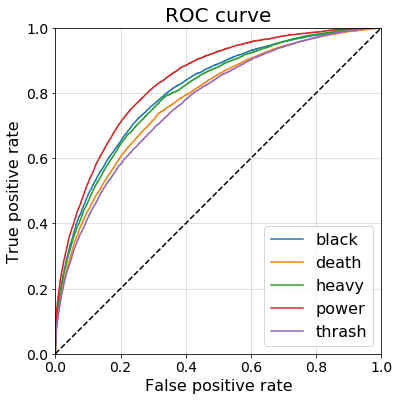

[0.80844213 0.78013289 0.80208243 0.83903864 0.7703175 ]
AUC ROC score = 0.80 +/- 0.02


In [18]:
rf_params = dict(
    n_estimators=1000,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('randomforest', RandomForestClassifier(**rf_params))
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# Gradient boosting model

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y[:, 0], shuffle=True, test_size=0.2)
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
X_valid_vec = vectorizer.transform(X_valid)
oversampler = RandomOverSampler(random_state=0)
X_train_vec, y_train = oversampler.fit_resample(X_train_vec, y_valid)

data_train = lgb.Dataset(X_train_vec.astype(float), y_train.astype(float))
data_valid = lgb.Dataset(X_test_vec.astype(float), y_valid.astype(float))

lgb_params = dict(n_estimators=1000, random_state=0, verbose=1, verbose_eval=1)
gbm = lgb.train(lgb_params, data_train, valid_sets=data_valid)

D:\Anaconda3\envs\metallyrics\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [23]:
lgb_params = dict(
    n_estimators=1000,
    random_state=0
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('lgb', lgb.LGBMClassifier(**lgb_params))
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

Training on label 'black'
Fold 1/3


OSError: exception: access violation reading 0x00000000000002A8

# Neural network

In [20]:
def create_keras_model(input_dim):
    model = Sequential()
    model.add(layers.Dense(64, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

def keras_batch_generator(X_data, y_data, batch_size):
    number_of_batches = X_data.shape[0] // batch_size
    counter = 0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X_data[index_batch, :].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch), y_batch
        if (counter > number_of_batches):
            counter = 0

Training on label 'black'
Fold 1/3
Epoch 1/2
52248/52248 [==============================] - 1s 16us/step - loss: 0.5517 - binary_accuracy: 0.7258
Epoch 2/2
52248/52248 [==============================] - 1s 13us/step - loss: 0.4911 - binary_accuracy: 0.7619
Fold 2/3
Epoch 1/2
52250/52250 [==============================] - 1s 15us/step - loss: 0.5499 - binary_accuracy: 0.7270
Epoch 2/2
52250/52250 [==============================] - 1s 13us/step - loss: 0.4868 - binary_accuracy: 0.7636
Fold 3/3
Epoch 1/2
52250/52250 [==============================] - 1s 15us/step - loss: 0.5541 - binary_accuracy: 0.7193
Epoch 2/2
52250/52250 [==============================] - 1s 13us/step - loss: 0.4879 - binary_accuracy: 0.7628
CV scores:
Accuracy:    0.74 +/- 0.00
Precision:   0.46 +/- 0.00
Recall:      0.73 +/- 0.01
F1-score:    0.57 +/- 0.00
Average confusion matrix:
[[0.58285782 0.19087014]
 [0.06195826 0.16431378]]
Training on label 'death'
Fold 1/3
Epoch 1/2
46016/46016 [===========================

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.27


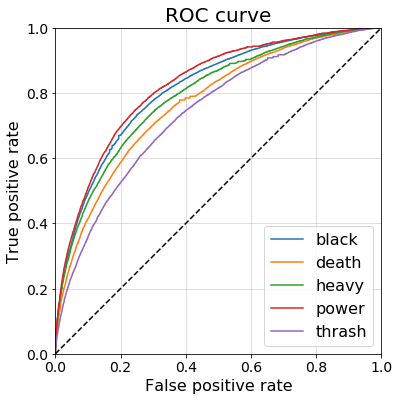

[0.81203449 0.76882326 0.79239632 0.82478355 0.73943716]
AUC ROC score = 0.79 +/- 0.03


In [21]:
keras_params = dict(
    input_dim=1024,
    epochs=2,
    batch_size=512,
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('selectkbest', SelectKBest(k=keras_params['input_dim'])),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('neuralnet', KerasClassifier(create_keras_model, **keras_params))
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# Stacked model

In [10]:
class StackedModel(BaseEstimator, TransformerMixin):
    def __init__(self, clfs=[], meta_clf=None):
        self.clfs = clfs
        self.meta_clf = meta_clf

    def fit(self, X, y, split_test_size=0.2):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size)
        y_prob = np.zeros((X_test.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            clf.fit(X_train, y_train)
            y_prob[:, j] = clf.predict_proba(X_test)[:, 1]
        self.meta_clf.fit(y_prob, y_test)
        return self

    def predict_base(self, X):
        y_prob = np.zeros((X.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            y_prob[:, j] = clf.predict_proba(X)[:, 1]
        return y_prob

    def predict(self, X):
        return self.meta_clf.predict(self.predict_base(X))

    def predict_proba(self, X):
        return self.meta_clf.predict_proba(self.predict_base(X))


training on feature 'black'
fold 1/3
fold 2/3
fold 3/3
CV score: 72.46% +/- 1.07%
Average confusion matrix:
[[0.61624578 0.15748218]
 [0.07856339 0.14770865]]
training on feature 'death'
fold 1/3
fold 2/3
fold 3/3
CV score: 69.46% +/- 0.44%
Average confusion matrix:
[[0.5410587  0.14036369]
 [0.12897111 0.18960649]]
training on feature 'heavy'
fold 1/3
fold 2/3
fold 3/3
CV score: 69.86% +/- 0.15%
Average confusion matrix:
[[0.71439572 0.12316623]
 [0.0740419  0.08839615]]
training on feature 'power'
fold 1/3
fold 2/3
fold 3/3
CV score: 71.62% +/- 0.40%
Average confusion matrix:
[[0.71421802 0.11479456]
 [0.07339033 0.09759709]]
training on feature 'thrash'
fold 1/3
fold 2/3
fold 3/3
CV score: 66.57% +/- 0.69%
Average confusion matrix:
[[0.6830217  0.12411397]
 [0.09929512 0.09356921]]
Multi-label classification report
Accuracy:   0.40
Precision:  0.50
Recall:     0.60
F1-score:   0.54


D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


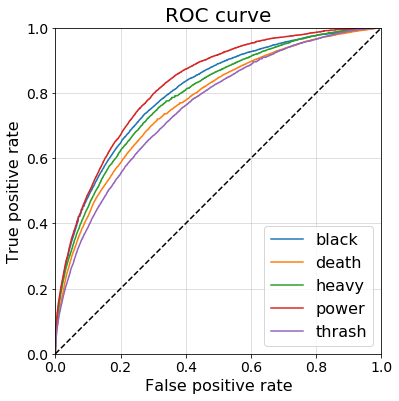

[0.8053241937314842,
 0.7701724475296019,
 0.7912542271348459,
 0.8260229136688134,
 0.7552315871119535]

In [22]:
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
stacked_model = StackedModel(
    [
        RandomForestClassifier(**rf_params)
    ],
    LogisticRegression(**lr_params)
)
n_splits = 5

pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('stackedmodel', stacked_model)
    ]
)
mlc = cross_validate_multilabel(df.lyrics.values, df_genres.values, pipeline, feature_names=df_genres.columns, n_splits=3, verbose=True)
mlc.print_report()
plot_roc_curve(mlc.true, mlc.pred, df_genres.columns)

## Stacking RF and NN with logreg aggregator

In [9]:
rf_params = dict(
    n_estimators=1000,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
keras_params = dict(
    input_dim=1000,
    epochs=2,
    batch_size=16,
)
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
stacked_model = StackedModel(
    [
        RandomForestClassifier(**rf_params),
        KerasClassifier(create_keras_model, **keras_params)
    ],
    LogisticRegression(**lr_params)
)

pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('kbest', SelectKBest(k=keras_params['input_dim']))
        ('oversampler', RandomOverSampler(random_state=0)),
        ('stackedmodel', stacked_model)
    ]
)

mlc = cross_validate_multilabel(df.lyrics.values, df_genres.values, pipeline, feature_names=df_genres.columns, n_splits=3, verbose=True)
mlc.print_report()
plot_roc_curve(mlc.true, mlc.pred, df_genres.columns)

NameError: name 'StackedModel' is not defined

In [33]:
feature_reducer = FeatureReducer(0)
oversampler = RandomOverSampler(random_state=0)
rf_params = dict(
    n_estimators=100,
    max_depth=30,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
nn_params = dict(
    epochs=1,
    batch_size=128
)
lr_params = dict(
    random_state=0
)
n_splits = 3

kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
scores = np.zeros(n_splits)
confusion_matrices = np.zeros((n_splits, 2, 2))

for i, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
    X_fold_valid, y_fold_valid = X_train[valid_idx], y_train[valid_idx]
    feature_reducer.fit(X_fold_train)
    X_fold_train = feature_reducer.transform(X_fold_train)
    X_fold_valid = feature_reducer.transform(X_fold_valid)
    X_fold_train, y_fold_train = oversampler.fit_resample(X_fold_train, y_fold_train)

    rf_model = RandomForestClassifier(**rf_params)
    keras_model = KerasClassifier(nn_model, input_dim=X_fold_train.shape[1], **nn_params)
    lr_model = LogisticRegression(**lr_params)
    clfs = [rf_model, keras_model]
    meta_clf = lr_model

    stacked_model = StackedModel([rf_model, keras_model], lr_model)
    stacked_model.fit(X_fold_train, y_fold_train)
    y_fold_pred = stacked_model.predict(X_fold_valid)

    scores[i] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    confusion_matrices[i] = confusion_matrix(y_fold_valid, y_fold_pred)

print("CV score: {:.2f}% +/- {:.2f}%".format(scores.mean()* 100, scores.std() * 200))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)

Epoch 1/1
30316/30316 [==============================] - 5s 149us/step - loss: 0.4279 - binary_accuracy: 0.8083


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
30318/30318 [==============================] - 5s 155us/step - loss: 0.4212 - binary_accuracy: 0.8162


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Epoch 1/1
30318/30318 [==============================] - 5s 154us/step - loss: 0.4244 - binary_accuracy: 0.8134


C:\Users\philippe\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CV score: 71.28% +/- 1.62%
Average confusion matrix:
[[0.75691828 0.07983985]
 [0.07819124 0.08505064]]


# References

1. Zhang, M., Li, Y., Liu, X. et al. Binary relevance for multi-label learning: an overview. Front. Comput. Sci. 12, 191–202 (2018). https://doi.org/10.1007/s11704-017-7031-7. 
    
    Go to http://palm.seu.edu.cn/zhangml/files/FCS'17.pdf for a free PDF view.

2. 